In [1]:
import os
os.chdir('../../src')

import datetime
import torch
import torch.nn as nn

from transformer.models import Transformer
from data import GPCurvesReader
from utils import plot_functions

In [2]:
TRAINING_ITERATIONS = int(2e5)
PLOT_AFTER = int(2e4)
MAX_CONTEXT_POINTS = 10
torch.manual_seed(0)

# Train dataset
dataset_train = GPCurvesReader(batch_size=64, max_num_context=MAX_CONTEXT_POINTS)
# Test dataset
dataset_test = GPCurvesReader(
    batch_size=100, max_num_context=MAX_CONTEXT_POINTS, testing=True
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Iteration: 0, train loss: 1.263702154159546
2025-01-29 16:49:52, Iteration: 0, Test Loss: 1.1763923168182373


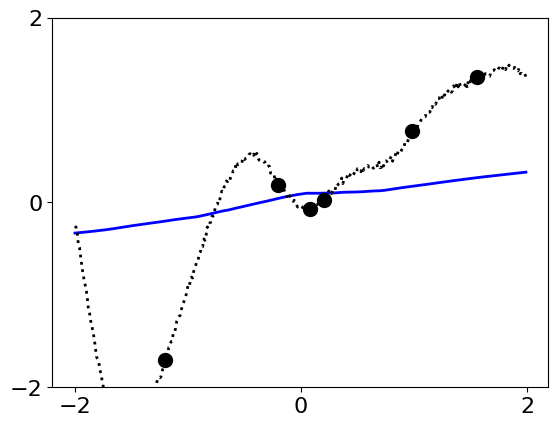

In [4]:
# Model
model = Transformer(x_dim=1, y_dim=1)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Training loop
for it in range(TRAINING_ITERATIONS + 1):
    # Sample a batch from the training dataset
    data_train = dataset_train.generate_curves()
    context_x, context_y, target_x, target_y, _, _ = data_train

    context_x = context_x.to(device)
    context_y = context_y.to(device)
    target_x = target_x.to(device)
    target_y = target_y.to(device)
    optimizer.zero_grad()

    preds = []

    for i in range(target_x.size(1)):
        x_t = target_x[:, i:i+1, :]
        pred = model(context_x, context_y, x_t)
        preds.append(pred)

    pred_y = torch.cat(preds, dim=1)
    loss = criterion(pred_y, target_y)

    loss.backward()
    optimizer.step()

    if it % 1000 == 0:
        print("Iteration: {}, train loss: {}".format(it, loss.item()))

    # Plot and print the loss every PLOT_AFTER iterations
    if it % PLOT_AFTER == 0:
        model.eval()
        with torch.no_grad():
            data_test = dataset_test.generate_curves()
            context_x, context_y, target_x, target_y, _, _ = data_test

            context_x = context_x.to(device)
            context_y = context_y.to(device)
            target_x = target_x.to(device)
            target_y = target_y.to(device)

            preds = []

            for i in range(target_x.size(1)):
                x_t = target_x[:, i:i+1, :]
                pred = model(context_x, context_y, x_t)
                preds.append(pred)

            pred_y = torch.cat(preds, dim=1)
            test_loss = criterion(pred_y, target_y)

            print(
                "{}, Iteration: {}, Test Loss: {}".format(
                    datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), it, test_loss.item()
                )
            )
            
            fig_dir = None
            if it in [160000, 180000, 200000]:
                fig_dir = '../images/1d_toy_regression/' + model.__class__.__name__ + '-' + str(it) + '.png'

            plot_functions(
                target_x.detach().cpu().numpy(),
                target_y.detach().cpu().numpy(),
                context_x.detach().cpu().numpy(),
                context_y.detach().cpu().numpy(),
                pred_y.detach().cpu().numpy(),
                save_fig=fig_dir,
            )

torch.save(model.state_dict(), '../models/1d_toy_regression/' + model.__class__.__name__ + '.pt')